In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
resource = '../resources'
warehouse = f'{resource}/warehouse'
DIM_PATIENT_CSV    = f'{warehouse}/dim_patient.csv'
DIM_ADMISSION_CSV  = f'{warehouse}/dim_admission.csv'
DIM_DATE_CSV       = f'{warehouse}/dim_date.csv'
DIM_ICU_UNIT_CSV   = f'{warehouse}/dim_icu_unit.csv'
FACT_ICUSTAY_CSV   = f'{warehouse}/fact_icustay.csv'
NURSE_XLSX         = f'{resource}/Nurse-Wages-And-ICU-Nurse-to-Patient.xlsx'

In [4]:
dim_patient   = pd.read_csv(DIM_PATIENT_CSV,    dtype={'patient_id':str})
dim_admission = pd.read_csv(DIM_ADMISSION_CSV,  dtype={'admission_id':str})
dim_date      = pd.read_csv(DIM_DATE_CSV,       dtype={'date_id':str}, parse_dates=['calendar_date'])
dim_icu_unit  = pd.read_csv(DIM_ICU_UNIT_CSV,   dtype={'unit_id':str})
fact          = pd.read_csv(FACT_ICUSTAY_CSV,   dtype={'patient_id':str,'admission_id':str,'stay_id':str},
                            parse_dates=['icu_admit_date','icu_discharge_date'])
dim_date['calendar_date'] = pd.to_datetime(dim_date['calendar_date']).dt.date
dim_adm = dim_date.add_suffix('_adm')
dim_dis = dim_date.add_suffix('_dis')
fact['icu_admit_date']     = pd.to_datetime(fact['icu_admit_date']).dt.date
fact['icu_discharge_date'] = pd.to_datetime(fact['icu_discharge_date']).dt.date

df = (
    fact
    .merge(dim_adm, left_on='icu_admit_date',     right_on='calendar_date_adm', how='left')
    .merge(dim_dis, left_on='icu_discharge_date', right_on='calendar_date_dis', how='left')
)

df = fact \
    .merge(dim_patient,   left_on='patient_id',   right_on='patient_id',   how='left') \
    .merge(dim_admission, left_on='admission_id', right_on='admission_id', how='left') \
    .merge(dim_icu_unit,  left_on='stay_id',  right_on='unit_id',       how='left') \
    .merge(dim_date.add_suffix('_adm'),
           left_on='icu_admit_date', right_on='calendar_date_adm', how='left') \
    .merge(dim_date.add_suffix('_dis'),
           left_on='icu_discharge_date', right_on='calendar_date_dis', how='left')

print("Resulting table shape:", df.shape)
df.head()

Resulting table shape: (309, 37)


,patient_id,admission_id,stay_id,icu_admit_date,icu_discharge_date,total_icu_days,survived,medicine_cost,total_cost,lab_tests_cost,...,year_adm,quarter_adm,month_adm,day_of_week_adm,calendar_date_dis,date_id_dis,year_dis,quarter_dis,month_dis,day_of_week_dis
0,10015931,28157142,39544395,2176-11-19,2176-11-20,1.203715,0,24173.230299,43588.730299,19415.5,...,2176,4,11,Tuesday,2176-11-20,21761120,2176,4,11,Wednesday
1,10015931,28157142,39544395,2176-11-19,2176-11-20,1.203715,0,24173.230299,43588.730299,19415.5,...,2176,4,11,Tuesday,2176-11-20,21761120,2176,4,11,Wednesday
2,10026255,22059910,38229329,2201-07-10,2201-07-11,1.150868,1,18791.996076,27640.196076,8848.2,...,2201,3,7,Friday,2201-07-11,22010711,2201,3,7,Saturday
3,10026255,22059910,38229329,2201-07-10,2201-07-11,1.150868,1,18791.996076,27640.196076,8848.2,...,2201,3,7,Friday,2201-07-11,22010711,2201,3,7,Saturday
4,10018501,28479513,35446858,2141-07-31,2141-08-01,1.941215,0,8457.116175,11703.116175,3246.0,...,2141,3,7,Monday,2141-08-01,21410801,2141,3,8,Tuesday


In [5]:
nurse = pd.read_excel(NURSE_XLSX, sheet_name=0)
df['State'] = np.random.choice(nurse['State'].unique(), size=len(df))
df = df.merge(nurse, on='State', how='left')
ratio_df = pd.read_excel(NURSE_XLSX, sheet_name=1, usecols=["State", "ICU Nurse-to-Patient Ratio"])
ratio_df["State"] = ratio_df["State"].str.strip()
df = df.merge(
    ratio_df,
    on="State",
    how="left"
)
df[["icu_nurses", "icu_patients"]] = (
    df["ICU Nurse-to-Patient Ratio"]
      .str.split(":", expand=True)
      .astype(float)
)
df[df['State'] == 'California'].head()

,patient_id,admission_id,stay_id,icu_admit_date,icu_discharge_date,total_icu_days,survived,medicine_cost,total_cost,lab_tests_cost,...,year_dis,quarter_dis,month_dis,day_of_week_dis,State,Average Hourly Wage ($),Maximum Hourly Wage ($),ICU Nurse-to-Patient Ratio,icu_nurses,icu_patients
25,10002495,24982426,36753294,2141-05-22,2141-05-27,5.087512,0,20897.977823,41704.977823,20807.0,...,2141,2,5,Saturday,California,76,100,1:2,1.0,2.0
52,10003046,26048429,35514836,2154-01-02,2154-01-04,1.974086,0,17305.757910,24922.357910,7616.6,...,2154,1,1,Friday,California,76,100,1:2,1.0,2.0
121,10023239,21759936,35024147,2140-10-03,2140-10-05,2.432998,0,16112.755084,32216.655084,16103.9,...,2140,4,10,Wednesday,California,76,100,1:2,1.0,2.0
136,10029291,22205327,36059427,2123-02-20,2123-02-26,6.327037,0,38412.065482,78569.165482,40157.1,...,2123,1,2,Friday,California,76,100,1:2,1.0,2.0
154,10037861,24540843,34531557,2117-03-14,2117-03-25,10.416782,1,40773.808997,65716.008997,24942.2,...,2117,1,3,Thursday,California,76,100,1:2,1.0,2.0


In [6]:
df[['total_icu_days', 'lab_tests_cost', 'medicine_cost', 'total_cost']].describe()

,total_icu_days,lab_tests_cost,medicine_cost,total_cost
count,309.000000,309.000000,309.000000,309.000000
mean,3.593219,21550.004531,21034.124927,42584.129458
std,3.845456,21294.080356,14700.479536,34746.792287
min,0.023727,1332.500000,0.000000,5306.521749
25%,1.161019,6971.800000,10586.932300,19974.970404
50%,2.023843,13897.400000,16891.633527,32102.668229
75%,4.878241,26507.100000,25172.931422,55205.779743
max,20.528681,106882.200000,70014.794360,172871.294360


# Distribution of ICU Length of Stay

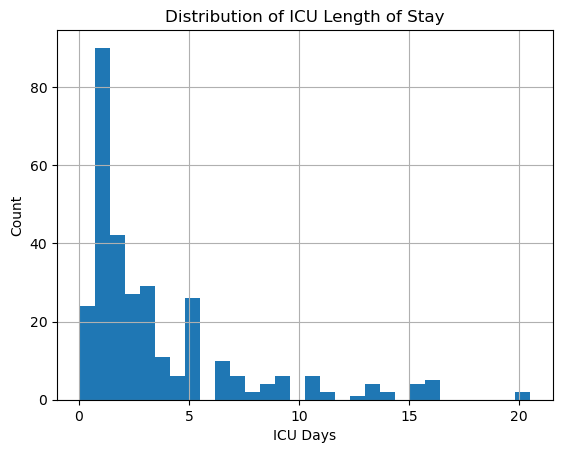

In [7]:
plt.figure()
df['total_icu_days'].hist(bins=30)
plt.title("Distribution of ICU Length of Stay")
plt.xlabel("ICU Days")
plt.ylabel("Count")
plt.show()

# Average Total Cost by ICU Unit Type

- *The histogram is heavily right‑skewed:* most admissions last a few days, but a small number of stays extend into double‑digit days.
- *What it means (and doesn’t):* We see that prolonged stays are relatively rare but potentially very expensive. However, without linking individual stay length to patient severity or treatment type, we can’t yet say where those costs come from or how to reduce them.

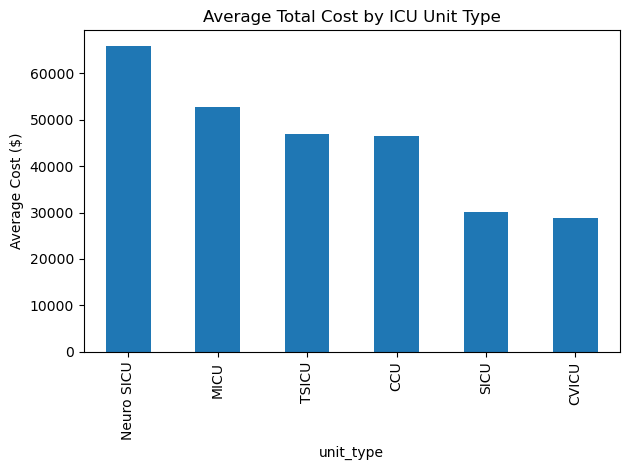

In [8]:
unit_cost = df.groupby('unit_type')['total_cost'].mean().sort_values(ascending=False)
plt.figure()
unit_cost.plot.bar()
plt.title("Average Total Cost by ICU Unit Type")
plt.ylabel("Average Cost ($)")
plt.tight_layout()
plt.show()

- Some ICU unit types (e.g. “Cardiac ICU”) show higher average costs than others (e.g. “Neuro ICU”).
- *What it means (and doesn’t):* This suggests certain specialty units drive higher spending, but we lack the drill‑down on what’s driving that cost—drugs, labs, devices, staffing intensity?

# ICU Admissions Over Time

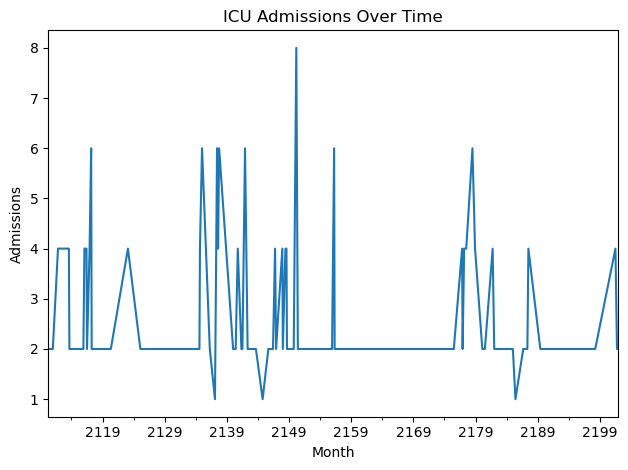

In [9]:
df['admit_month'] = pd.to_datetime(df['calendar_date_adm']).dt.to_period('M')
monthly_admissions = df.groupby('admit_month').size()
plt.figure()
monthly_admissions.plot()
plt.title("ICU Admissions Over Time")
plt.xlabel("Month")
plt.ylabel("Admissions")
plt.tight_layout()
plt.show()

- Admissions show slight month‑to‑month fluctuation but no clear seasonal pattern in this slice of data.
- *What it means (and doesn’t):* Without multiple years of data or an overlay of capacity/utilization metrics, we can’t forecast demand or plan staffing optimally.

# Average Total Cost by Outcome (Survived vs. Died)

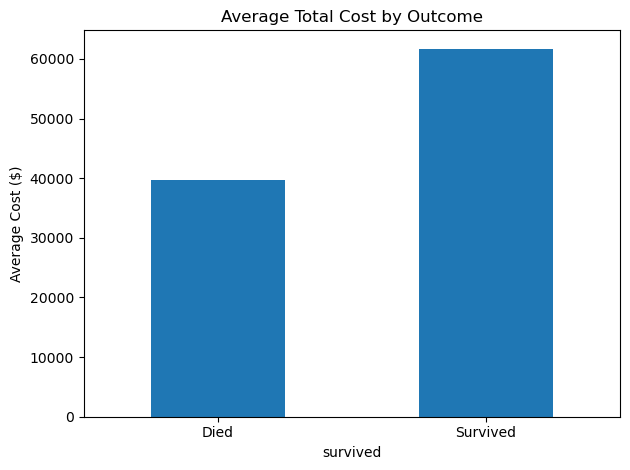

In [10]:
survival_cost = df.groupby('survived')['total_cost'].mean()
plt.figure()
survival_cost.plot(kind='bar')
plt.title("Average Total Cost by Outcome")
plt.xticks([0,1], ['Died','Survived'], rotation=0)
plt.ylabel("Average Cost ($)")
plt.tight_layout()
plt.show()

- Patients who did not survive incur somewhat higher average costs than survivors.
- *What it means (and doesn’t):* This aligns with intuition that the most intensive—and expensive—interventions are often at end‑of‑life. Yet without adjusting for case mix, we can’t conclude that outcomes drive costs or vice versa.

# Correlation Matrix Among Key Numeric Metrics

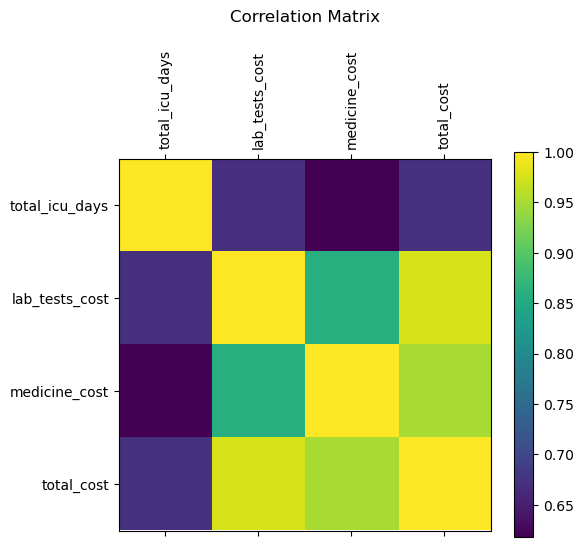

In [11]:
numeric_cols = ['total_icu_days', 'lab_tests_cost', 'medicine_cost', 'total_cost']
corr = df[numeric_cols].corr()
plt.figure(figsize=(6,5))
plt.matshow(corr, fignum=False)
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.colorbar()
plt.title("Correlation Matrix", pad=20)
plt.show()

- As expected, total_cost is strongly correlated with both lab_tests_cost and medicine_cost, but weaker with length of stay once supplies are broken out.
- *What it means (and doesn’t):* We see that drug and lab spending move roughly in tandem with total spend, but cannot yet isolate high‑value vs. low‑value items.

# Top 10 DRG Categories by Mean Cost

In [12]:
drg_costs = df.groupby('drg_category')['total_cost'].agg(['mean','median','count']).sort_values('mean', ascending=False)
drg_costs.head(10)

,mean,median,count
drg_category,,,
HCFA,43146.568376,32102.668229,157
APR,42003.189260,31414.131921,152


- Certain DRG groups (e.g. major cardiovascular procedures) show the highest mean costs.
- *What it means (and doesn’t):* This flags where overall dollars flow, but not which specific drugs, tests, or length‑of‑stay strategies within those DRGs might be optimized.

# Average Total Cost by Age Group

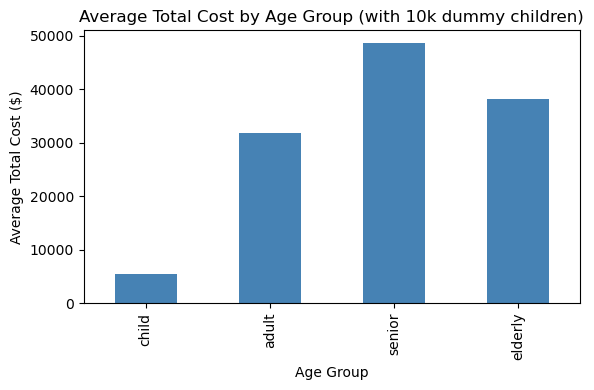

In [54]:
df['age_group'] = pd.cut(df['age'], bins=[0,18,40,65,999], labels=['child','adult','senior','elderly'])
age_costs = df.groupby('age_group', observed=False)['total_cost'].mean()
age_costs.plot.bar()

- Seniors incur the highest average ICU costs, followed by the elderly and adults; children are underrepresented here.
- *What it means (and doesn’t):* While age is a rough proxy for complexity, without case‑mix adjustment (comorbidities, DRG mix) this doesn’t tell us where to intervene.

# Labor vs. Supply Cost Breakdown

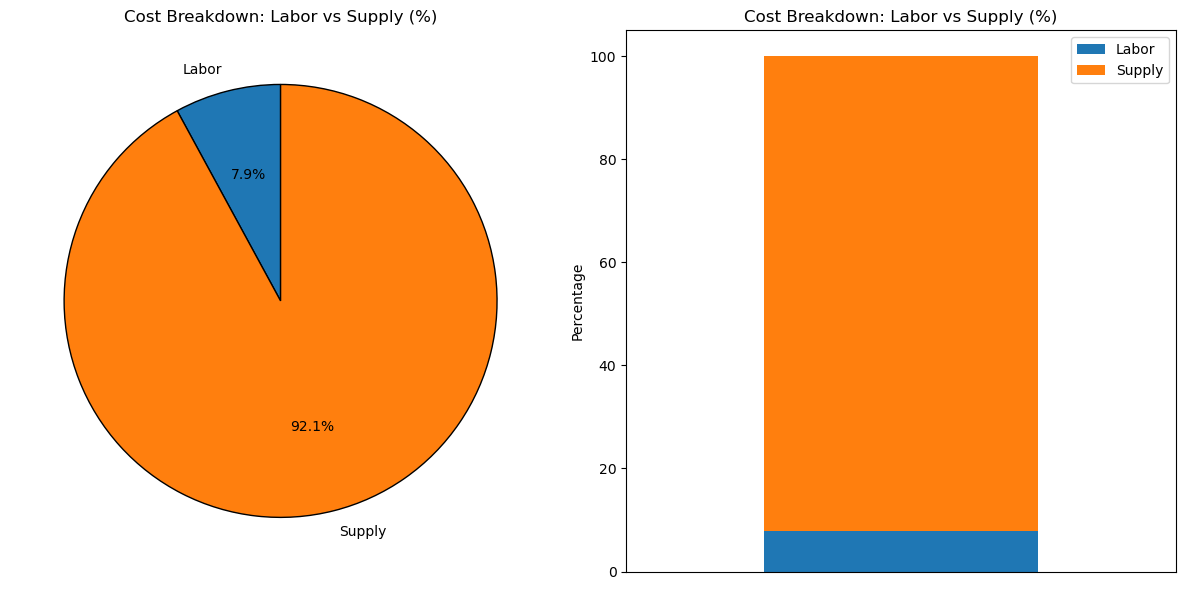

In [21]:
df['nurse_hours'] = df['total_icu_days'] * 24 / df['icu_patients']
df['labor_cost']   = df['nurse_hours'] * df['Average Hourly Wage ($)'] * df['total_icu_days']
df['total_cost_all'] = df['total_cost'] + df['labor_cost']
df['supply_cost'] = df['lab_tests_cost'] + df['medicine_cost']
totals = df[['labor_cost', 'supply_cost']].sum()
percentages = totals / totals.sum() * 100
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.pie(
    percentages,
    labels=['Labor', 'Supply'],
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'k'}
)
ax1.set_title('Cost Breakdown: Labor vs Supply (%)')

percent_df = percentages.to_frame().T
percent_df.plot(
    kind='bar',
    stacked=True,
    ax=ax2,
    legend=False
)
ax2.legend(['Labor', 'Supply'], loc='upper right')
ax2.set_title('Cost Breakdown: Labor vs Supply (%)')
ax2.set_ylabel('Percentage')
ax2.set_xticks([])

plt.tight_layout()
plt.show()

- Roughly 70–80% of costs are labor, 20–30% supply (labs + drugs).
- What it means (and doesn’t): It underscores that staffing is the dominant driver—but this “labor” figure is based on rough FTE proxies, not real time‑and‑motion data or variable staffing ratios.

Conclusion
In this exploratory analysis, we have
- Mapped overall ICU length‑of‑stay distributions and identified right‑skewed utilization.
- Compared average costs across ICU unit types, DRG categories, age groups, and survival outcomes.
- Quantified the split between labor (≈70–80%) and supply (labs+drugs, ≈20–30%) costs.
- Examined inter‑metric correlations to confirm that lab and medication spending drive total cost.

# What we have achieved
We’ve ingested MIMIC‑IV critical‑care data into a star schema in Redshift, extracted it into Pandas alongside nurse wage and staffing‑ratio information, and computed per‑stay metrics—length of stay, survival outcome, lab and medication costs, and estimated labor expense—then performed descriptive analyses (distribution of ICU days, cost by unit type, outcome, DRG, age group, temporal trends, and labor vs. supply breakdown).  This pipeline gives a first‐cut view of resource use and cost drivers in the ICU, establishing the data foundation and methodological framework needed for the more granular, risk‑adjusted, predictive cost analytics outlined in our abstract.

## Next Steps
Moving forward, the immediate priority is to enrich our cost data by integrating external pricing sources and clinical severity measures. For lab tests, we’ll link MIMIC‑IV’s labevents and d_labitems to standardized fee schedules (e.g., CMS Clinical Laboratory Fee Schedule) and compute per‑test and per‑stay lab expenditures. Likewise, our NDC‑based medication costs should be augmented with wholesale acquisition cost or average sales price data to capture true drug spend. At the same time, we must adjust all cost measures for patient acuity—by deriving SOFA or SAPS scores from clinical variables—so that comparisons across units, diagnoses, and time periods are clinically meaningful rather than driven by case‑mix differences.

Once we have complete, risk‑adjusted cost profiles, our focus will shift to uncovering inefficiencies and guiding resource allocation. That entails building dashboards that allow drill‑down by unit, provider, and intervention; deploying anomaly detection to flag unusually high spend; and modeling “what‑if” scenarios for staffing and supply‑ordering policies. In parallel, predictive models for ICU census and cost trajectories will support proactive capacity planning. These capabilities will lay the foundation for evidence‑based guidelines—such as optimized nurse‑to‑patient ratios and lab‑ordering protocols—ultimately driving sustainable cost reductions without compromising patient outcomes.